In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import pandas as pd

# Data exploration

We first load the data. As an example, we select the first data point and normalize the 70 epochs over 20 minutes.

In [2]:
result_dir = "../code/games/pong/results/FlatDQN/BALL_SPEED_1.0/"
simulations = [os.path.join(result_dir, x) for x in os.listdir(result_dir)]

FileNotFoundError: [Errno 2] No such file or directory: '../code/games/pong/results/FlatDQN/BALL_SPEED_1.0/'

In [3]:
min20 = 20*60

In [4]:
def get_simulation_results(simulation):
    with open(simulation,"r") as f:
        data_point = json.load(f)

        simulation_results = data_point[1:]


        scale = min20/simulation_results[-1]['norm_timestamp']
        # normalize time
        for i in range(len(simulation_results)):
            simulation_results[i]["scaled_time"] = simulation_results[i]["norm_timestamp"]*scale
    return simulation_results

In [5]:
simulation_results = get_simulation_results(simulations[0])

NameError: name 'simulations' is not defined

Now, divide the actions per minutes, in order to obtain the statistics per minute.

In [6]:
# per minute splits 
def split_per_minute(simulation_results):
    minutes_recordings = []
    j = 0
    for i in range(60, 1201, 60):

        per_minute_recordings = []

        for s in simulation_results:
            if s["scaled_time"]>i-60 and s["scaled_time"]<=i:
                per_minute_recordings.append(s)
                j+=1

        minutes_recordings.append(per_minute_recordings)

    return minutes_recordings
    
minutes_recordings = split_per_minute(simulation_results)
print("Number of minutes:", len(minutes_recordings))

NameError: name 'simulation_results' is not defined

Let's explore the data for the 2nd minute (between 60 and 120 seconds):

In [7]:
minutes_recordings[1]

NameError: name 'minutes_recordings' is not defined

All set! Now let's compute some statistics on this data:

In [8]:
def filter_events(minute):
    bounces = [e for e in minute if e["event"]=="ball bounce"]
    hits = [e for e in minute if e["event"]=="ball return"]
    
    # detect aces
    aces = []
    for i in range(len(minute)):
        if minute[i]["event"]=="motor layout: 0":
            # try to find next ace
            for j in range(0, len(minute)-i):
                if minute[i+j]["event"]=="ball return":
                    break # no ace
                if minute[i+j]["event"]=="ball missed":
                    aces.append(minute[i+j]) # ace detected
                    break
                    
    # detect long_rallies
    rallies = []
    for i in range(len(minute)):
        
        if minute[i]["event"]=="motor layout: 0":
            
            rally = []
            
            # try to find next return
            for j in range(0, len(minute)-i):
                if minute[i+j]["event"]=="ball return":
                    rally.append(minute[i+j])
                if minute[i+j]["event"]=="ball missed":
                    rallies.append(rally)
                    break
                    
    rally_end=[] 
    for i in range(len(minute)):
        if minute[i]["event"]=="ball missed":
            rally_end.append(minute[i])
                                 
    return {
        "bounces": bounces,
        "aces":aces,
        "hits":hits,
        "rallies":rallies,
        "misses": rally_end
    }

In [9]:
stats = filter_events(simulation_results)

NameError: name 'simulation_results' is not defined

In [10]:
def stats_to_scatter(stats):
    plt.figure()
    ax = plt.subplot(111)
    keys = list(stats.keys())
    for i in range(len(keys)):

        label = keys[i]
        if label!="rallies":
            times =  [s["scaled_time"] for s in stats[label]]
            ax.scatter(times, [i for _ in range(len(times))], label=label)
        else:
            last_times = [s[-1]["scaled_time"] for s in stats[label] if len(s)>3]
            ax.scatter(last_times, [i for _ in range(len(last_times))], label="long rallies (>3)")

    ax.set_yticks([])
    ax.set_ylim(4.1, -0.1)
    ax.set_xlabel("seconds")
    ax.legend()
    return ax

In [11]:
ax = stats_to_scatter(stats)

NameError: name 'stats' is not defined

In [12]:
stats["misses"][0]

NameError: name 'stats' is not defined

Now, display as a vector

In [13]:
# create a numpy array per second, with the events
def stats_to_image(stats):
    event_array = np.zeros((4,1200))

    keys = list(stats.keys())
    for i in range(len(keys)):

        label = keys[i]
        if label!="rallies":
            times =  [int(np.round(s["scaled_time"])) for s in stats[label]]
            for t in times:
                if t<min20:
                    event_array[i, t] = 1
        else:
            last_times = [int(np.round(s[-1]["scaled_time"])) for s in stats[label] if len(s)>3]
            for t in last_times:
                if t<min20:
                    event_array[i, t] = 1
    return event_array

In [14]:
image = stats_to_image(stats)
ax = stats_to_scatter(stats)
ax.imshow(image, aspect="auto")

NameError: name 'stats' is not defined

Finally, let's get the stats per minute:

In [15]:
def get_minute_stats(image):
    minute_stats = []

    for t in range(0, image.shape[1], 60):
        minute = image[:, t:t+60]
        stats = minute.mean(1)
        minute_stats.append(stats)

    return minute_stats

In [16]:
minute_stats = get_minute_stats(image)

NameError: name 'image' is not defined

In [17]:
# transform as pd:
def stats_to_pd(minute_stats):
    data_dict = []
    for i in range(len(minute_stats)):
        d = [{"time":i, "value":minute_stats[i][0], "event_type":"bounce"},
             {"time":i, "value":minute_stats[i][1], "event_type":"aces"},
             {"time":i, "value":minute_stats[i][2], "event_type":"hits"},
             {"time":i, "value":minute_stats[i][3], "event_type":"long_rallies"}
            ]
        data_dict+=(d)

    df = pd.DataFrame(data_dict)
    return df

df = stats_to_pd(minute_stats)
df

NameError: name 'minute_stats' is not defined

In [18]:
sns.scatterplot(df[df.event_type=="hits"], x="time",y="value")

NameError: name 'df' is not defined

Nice! Now let's analyze all the data.

## Results on DQN

In [19]:
def divide_dataset(data, chunk_size):
    chunks = []
    current_chunk = []
    current_time = data[0]['scaled_time']
    
    for item in data:
        if item['scaled_time'] - current_time <= chunk_size:
            current_chunk.append(item)
        else:
            chunks.append(current_chunk)
            current_chunk = [item]
            current_time = item['scaled_time']
    
    if current_chunk:
        chunks.append(current_chunk)
    
    return chunks

In [20]:
def get_rallies_per_minutes(stats):
    rallies = stats["rallies"]
    ends = stats["misses"]
    
    hits_per_rallies = []
    for i in range(len(rallies)):
        v = {"value":len(rallies[i]),
        "time":ends[i]["scaled_time"]}
        hits_per_rallies.append(v)
    return hits_per_rallies

In [49]:
chunk_size = 30

def get_aces_ratio(simulation_results):
    sim = [x for x in simulation_results if x["event"]!="ball bounce"]
    chunks = divide_dataset(sim, chunk_size)
    
    aces_across_time = []
    for c in range(len(chunks)):
        events_without_bounce = chunks[c] # this is not useful here
        game_started_next_hit, game_started_next_miss = [], []
        for i in range(len(events_without_bounce) - 1): # iterate up to the second-to-last element
            if events_without_bounce[i]['event'] == 'motor layout: 0':
                next_event = events_without_bounce[i+1]
                if next_event['event'] == 'ball missed' :
                    game_started_next_miss.append(next_event)
                elif next_event['event'] == 'ball return' :
                    game_started_next_hit.append(next_event)

        aces = len(game_started_next_miss)
        successfull_init_returns = len(game_started_next_hit)
        ratio_aces = aces/(aces+successfull_init_returns+1e-9)
        aces_across_time.append({"time":c*chunk_size,
                                "value":ratio_aces*100})
    return aces_across_time

def get_percentage_long(simulations_results):
    sim = [x for x in simulation_results if x["event"]!="ball bounce"]
    chunks = divide_dataset(sim, chunk_size)

    percentage_across = []
    for c in range(len(chunks)):
        rallies = [x for x in chunks[c] if x["event"]!="ball missed" and x["event"]!="game begin"]
        num_rallies = len([x for x in chunks[c] if x["event"]=="motor layout: 0"])

        n=0
        length_rallies = []
        for i in range(len(rallies)):

            if rallies[i]["event"]=="ball return":
                n=n+1
            else:
                length_rallies.append(n)
                n=0
        
        if len(length_rallies):
            percentage_long = len([x for x in length_rallies if x>3])/len(length_rallies)
            percentage_across.append({"time":c*chunk_size,
                                    "value":percentage_long*100})

    return percentage_across


def get_rally_hits(simulations_results):
    sim = [x for x in simulation_results if x["event"]!="ball bounce"]
    chunks = divide_dataset(sim, chunk_size)

    rally_hits = []
    for c in range(len(chunks)):
        rallies = [x for x in chunks[c] if x["event"]!="ball missed" and x["event"]!="game begin"]
        num_rallies = len([x for x in chunks[c] if x["event"]=="motor layout: 0"])

        n=0
        length_rallies = []
        for i in range(len(rallies)):

            if rallies[i]["event"]=="ball return":
                n=n+1
            else:
                length_rallies.append(n)
                n=0
        
        if len(length_rallies):
            mean_length = np.mean(length_rallies)
            rally_hits.append({"time":c*chunk_size,
                                    "value":mean_length})

    return rally_hits


In [50]:
# loop over simulations
hits_per_rally = []
aces_ratios = []
long_ratios = []

for ball_speed in [1.0]:
    result_dir = "../code/games/pong/results/DQN/BALL_SPEED_{}/".format(ball_speed)
    simulations = [os.path.join(result_dir, x) for x in os.listdir(result_dir)]

    for r in simulations:
        simulation_results = get_simulation_results(r)
        stats = filter_events(simulation_results)
        
        h = get_rally_hits(stats)
        df=pd.DataFrame(h)
        df["ball_speed"] = ball_speed
        hits_per_rally.append(df)
        
        a = get_aces_ratio(simulation_results)
        df = pd.DataFrame(a)
        df["ball_speed"] = ball_speed
        aces_ratios.append(df)
        
        p = get_percentage_long(simulation_results)
        df = pd.DataFrame(p)
        df["ball_speed"] = ball_speed
        long_ratios.append(df)
        
H = pd.concat(hits_per_rally)
A = pd.concat(aces_ratios)
L = pd.concat(long_ratios)

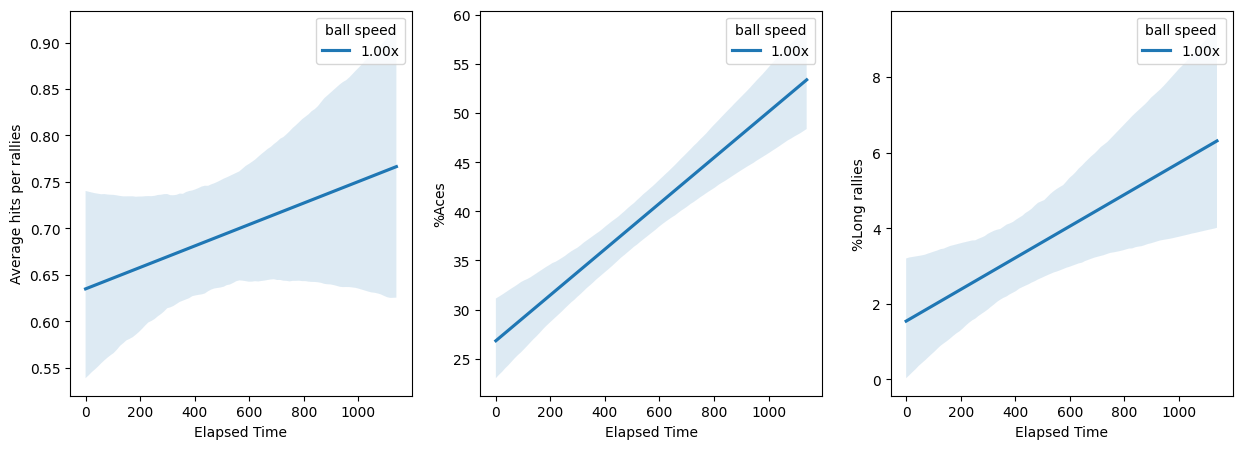

In [51]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)

sns.regplot(x="time", y="value", data=H[H.ball_speed==1.0], ax = ax, scatter=False, label="1.00x")
sns.regplot(x="time", y="value", data=H[H.ball_speed==2.0], ax=ax, scatter=False, label="2.00x")
sns.regplot(x="time", y="value", data=H[H.ball_speed==0.5], ax=ax, scatter=False, label="0.50x")
ax.legend(title="ball speed")
ax.set_ylabel("Average hits per rallies")
ax.set_xlabel("Elapsed Time")

ax = plt.subplot(1,3,2)

sns.regplot(x="time", y="value", data=A[A.ball_speed==1.0], ax = ax, scatter=False, label="1.00x")
sns.regplot(x="time", y="value", data=A[A.ball_speed==2.0], ax=ax, scatter=False, label="2.00x")
sns.regplot(x="time", y="value", data=A[A.ball_speed==0.5], ax=ax, scatter=False, label="0.50x")
ax.legend(title="ball speed")
ax.set_ylabel("%Aces")
ax.set_xlabel("Elapsed Time")


ax = plt.subplot(1,3,3)

sns.regplot(x="time", y="value", data=L[L.ball_speed==1.0], ax = ax, scatter=False, label="1.00x")
sns.regplot(x="time", y="value", data=L[L.ball_speed==2.0], ax=ax, scatter=False, label="2.00x")
sns.regplot(x="time", y="value", data=L[L.ball_speed==0.5], ax=ax, scatter=False, label="0.50x")
ax.legend(title="ball speed")
ax.set_ylabel("%Long rallies")
ax.set_xlabel("Elapsed Time")
plt.show()

In [52]:
os.listdir("../code/games/pong/results/DQN/")

['BALL_SPEED_1.0']

# Results per model

In [53]:
models = os.listdir("../code/games/pong/results/")
models

['Chance', 'DQN', 'DQN8', 'DQN+', 'DQN8-onlypos']

In [54]:
# Results across different models
# loop over simulations
hits_per_rally = []
aces_ratios = []
long_ratios = []
ball_speed = 1.0

for model in models:
    result_dir = "../code/games/pong/results/{}/BALL_SPEED_{}/".format(model, ball_speed)
    if not os.path.exists(result_dir):
        print("skip", result_dir)
        continue
    simulations = [os.path.join(result_dir, x) for x in os.listdir(result_dir)]

    for r in simulations:
        simulation_results = get_simulation_results(r)
        stats = filter_events(simulation_results)
        
        h = get_rallies_per_minutes(stats)
        df=pd.DataFrame(h)
        df["ball_speed"] = ball_speed
        df["model"] = model
        hits_per_rally.append(df)
        
        a = get_aces_ratio(simulation_results)
        df = pd.DataFrame(a)
        df["ball_speed"] = ball_speed
        df["model"] = model
        aces_ratios.append(df)
        
        p = get_percentage_long(simulation_results)
        df = pd.DataFrame(p)
        df["ball_speed"] = ball_speed
        df["model"] = model
        long_ratios.append(df)
        
H = pd.concat(hits_per_rally)
A = pd.concat(aces_ratios)
L = pd.concat(long_ratios)

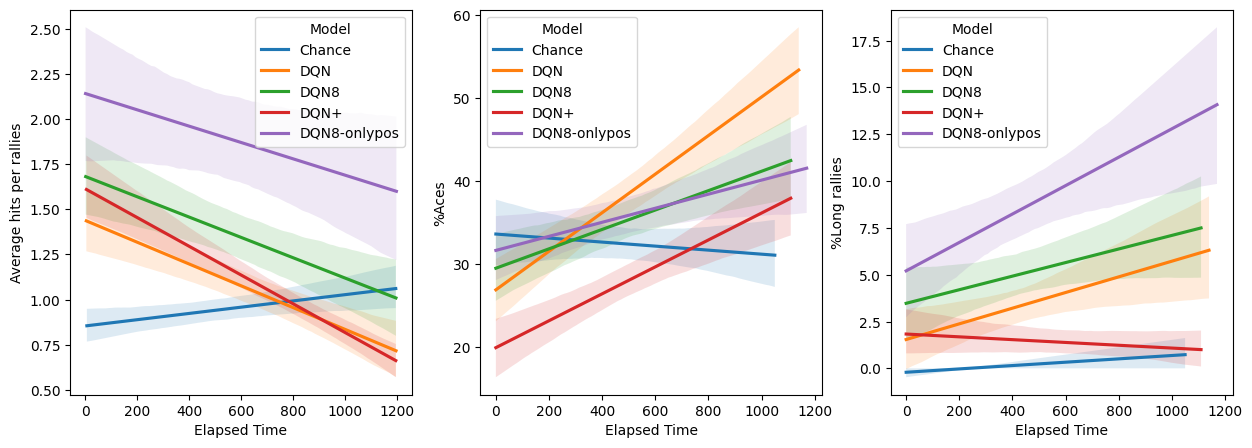

In [55]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)

for model in models:
    sns.regplot(x="time", y="value", data=H[H.model==model], ax = ax, scatter=False, label=model)
ax.legend(title="Model")
ax.set_ylabel("Average hits per rallies")
ax.set_xlabel("Elapsed Time")

ax = plt.subplot(1,3,2)

for model in models:
    sns.regplot(x="time", y="value", data=A[A.model==model], ax = ax, scatter=False, label=model)
ax.legend(title="Model")
ax.set_ylabel("%Aces")
ax.set_xlabel("Elapsed Time")


ax = plt.subplot(1,3,3)

for model in models:
    sns.regplot(x="time", y="value", data=L[L.model==model], ax = ax, scatter=False, label=model)
ax.legend(title="Model")
ax.set_ylabel("%Long rallies")
ax.set_xlabel("Elapsed Time")
plt.show()